<a href="https://colab.research.google.com/github/Auzek2002/Spaceship_Titanic_Kaggle/blob/main/SpaceShip_Titanic_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [413]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalAveragePooling2D
from zipfile import ZipFile
import os,glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.models import Model
from sklearn import preprocessing
from keras.layers import BatchNormalization
from zipfile import ZipFile
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [414]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


Loading the Data:

In [415]:
!kaggle competitions download -c spaceship-titanic

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [416]:
file = "/content/spaceship-titanic.zip"
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [417]:
df = pd.read_csv("/content/train.csv")

Exploaring the Data:

In [418]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [419]:
df.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [420]:
df.shape

(8693, 14)

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [422]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [423]:
df.describe(include=['bool','object'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,8693,8492,8476,8494,8511,8490,8493,8693
unique,8693,3,2,6560,3,2,8473,2
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive,True
freq,1,4602,5439,8,5915,8291,2,4378


Checking for NUll values:

In [424]:
df.isnull()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8689,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8690,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8691,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [425]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [426]:
df.duplicated().sum()

0

Data Cleaning:

In [427]:
df.drop(columns=['PassengerId','Name'],axis=1,inplace=True)

In [428]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [429]:
df.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


In [431]:
#People in CryoSleep don't pay for food etc
cols_to_be_zero = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cols_to_be_false = ['VIP']
condition = (df['CryoSleep']==True)
df.loc[~condition,cols_to_be_zero] = df.loc[~condition,cols_to_be_zero].fillna(0)
df.loc[~condition,cols_to_be_false] = df.loc[~condition,cols_to_be_false].fillna(False)

In [432]:
cols_to_be_zero = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cryo_col = ['CryoSleep']
cond = (df[cols_to_be_zero].eq(0).all(axis=1))
df.loc[~cond,cryo_col]=df.loc[~cond,cryo_col].fillna(True)

In [433]:
df['CryoSleep'].fillna(False,inplace=True)

In [434]:
df.isnull().sum()

HomePlanet      201
CryoSleep         0
Cabin           199
Destination     182
Age             179
VIP              75
RoomService      68
FoodCourt        70
ShoppingMall     96
Spa              65
VRDeck           62
Transported       0
dtype: int64

Splitting the cabin column:

In [435]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [436]:
cabin_split = df['Cabin'].str.split('/',expand=True)
cabin_split.columns=['Deck','Num','Side']
new_df = pd.concat([df,cabin_split],axis=1)
df = new_df

In [437]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [438]:
df.drop(['Cabin'],axis=1,inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


Filling Age Missing Values using mean age group by HomePlanet and CryoSleep

In [439]:
group_mean = df.groupby(['HomePlanet','CryoSleep'])['Age'].mean()
print(group_mean)

HomePlanet  CryoSleep
Earth       False        27.298421
            True         23.362863
Europa      False        35.580700
            True         32.932166
Mars        False        29.605944
            True         28.818722
Name: Age, dtype: float64


In [440]:
group_m = df.groupby(['HomePlanet','CryoSleep'],group_keys=True)['Age'].mean().reset_index(name='Age_mean')
df = df.merge(group_m,on=['HomePlanet','CryoSleep'],how='left')
df['Age']=df['Age'].fillna(df['Age_mean'])

In [441]:
df.drop(['Age_mean'],axis=1,inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


In [442]:
df.isnull().sum()

HomePlanet      201
CryoSleep         0
Destination     182
Age               2
VIP              75
RoomService      68
FoodCourt        70
ShoppingMall     96
Spa              65
VRDeck           62
Transported       0
Deck            199
Num             199
Side            199
dtype: int64

In [443]:
cat_features = ['HomePlanet','Destination','VIP','Deck','Num','Side']
df['HomePlanet'].fillna(df['HomePlanet'].mode()[0],axis=0,inplace=True)
df['Destination'].fillna(df['Destination'].mode()[0],axis=0,inplace=True)
df['VIP'].fillna(df['VIP'].mode()[0],axis=0,inplace=True)
df['Deck'].fillna(df['Deck'].mode()[0],axis=0,inplace=True)
df['Num'].fillna(df['Num'].mode()[0],axis=0,inplace=True)
df['Side'].fillna(df['Side'].mode()[0],axis=0,inplace=True)

In [444]:
df.isnull().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              2
VIP              0
RoomService     68
FoodCourt       70
ShoppingMall    96
Spa             65
VRDeck          62
Transported      0
Deck             0
Num              0
Side             0
dtype: int64

In [445]:
df['RoomService'].fillna(df['RoomService'].mean(),axis=0,inplace=True)
df['FoodCourt'].fillna(df['FoodCourt'].mean(),axis=0,inplace=True)
df['ShoppingMall'].fillna(df['ShoppingMall'].mean(),axis=0,inplace=True)
df['Spa'].fillna(df['Spa'].mean(),axis=0,inplace=True)
df['VRDeck'].fillna(df['VRDeck'].mean(),axis=0,inplace=True)
df['Age'].fillna(df['Age'].mean(),axis=0,inplace=True)

In [446]:
df.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Num             0
Side            0
dtype: int64

In [447]:
print(f"Unique values for CryoSleep: {df['CryoSleep'].unique()}")
print(f"Unique values for HomePlanet: {df['HomePlanet'].unique()}")
print(f"Unique values for Destination: {df['Destination'].unique()}")
print(f"Unique values for VIP: {df['VIP'].unique()}")

Unique values for CryoSleep: [False  True]
Unique values for HomePlanet: ['Europa' 'Earth' 'Mars']
Unique values for Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
Unique values for VIP: [False  True]


In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8693 non-null   object 
 12  Num           8693 non-null   object 
 13  Side          8693 non-null   object 
dtypes: bool(3), float64(6), object(5)
memory usage: 840.4+ KB


In [449]:
df['Num']=df['Num'].astype(np.float64)

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8693 non-null   object 
 12  Num           8693 non-null   float64
 13  Side          8693 non-null   object 
dtypes: bool(3), float64(7), object(4)
memory usage: 840.4+ KB


In [451]:
df['Side'].unique()

array(['P', 'S'], dtype=object)

In [452]:
df['Deck'].unique()

array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object)

In [453]:
df=pd.get_dummies(data=df,columns=['HomePlanet','Destination','Deck','Side'],drop_first=True)

In [454]:
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0,1,1,0,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0.0,...,0,1,0,0,0,0,1,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0.0,...,0,1,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0.0,...,0,1,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1.0,...,0,1,0,0,0,0,1,0,0,1


In [455]:
df.shape

(8693, 22)

In [456]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   bool   
 9   Num                        8693 non-null   float64
 10  HomePlanet_Europa          8693 non-null   uint8  
 11  HomePlanet_Mars            8693 non-null   uint8  
 12  Destination_PSO J318.5-22  8693 non-null   uint8  
 13  Destination_TRAPPIST-1e    8693 non-null   uint8

In [457]:
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Num,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0,1,1,0,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0.0,...,0,1,0,0,0,0,1,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0.0,...,0,1,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0.0,...,0,1,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1.0,...,0,1,0,0,0,0,1,0,0,1


                           CryoSleep       Age       VIP  RoomService  \
CryoSleep                   1.000000 -0.067937 -0.077171    -0.231099   
Age                        -0.067937  1.000000  0.091573     0.067945   
VIP                        -0.077171  0.091573  1.000000     0.056188   
RoomService                -0.231099  0.067945  0.056188     1.000000   
FoodCourt                  -0.194421  0.129488  0.125408    -0.016643   
ShoppingMall               -0.197782  0.032870  0.017935     0.050585   
Spa                        -0.189157  0.122924  0.060905     0.007865   
VRDeck                     -0.183029  0.100881  0.123006    -0.019962   
Transported                 0.444270 -0.073887 -0.037261    -0.239857   
Num                        -0.038917 -0.130832 -0.097011    -0.012274   
HomePlanet_Europa           0.091945  0.221932  0.147008    -0.066725   
HomePlanet_Mars             0.031197  0.016537  0.043523     0.245449   
Destination_PSO J318.5-22   0.086270 -0.029493 -0.0

<Axes: >

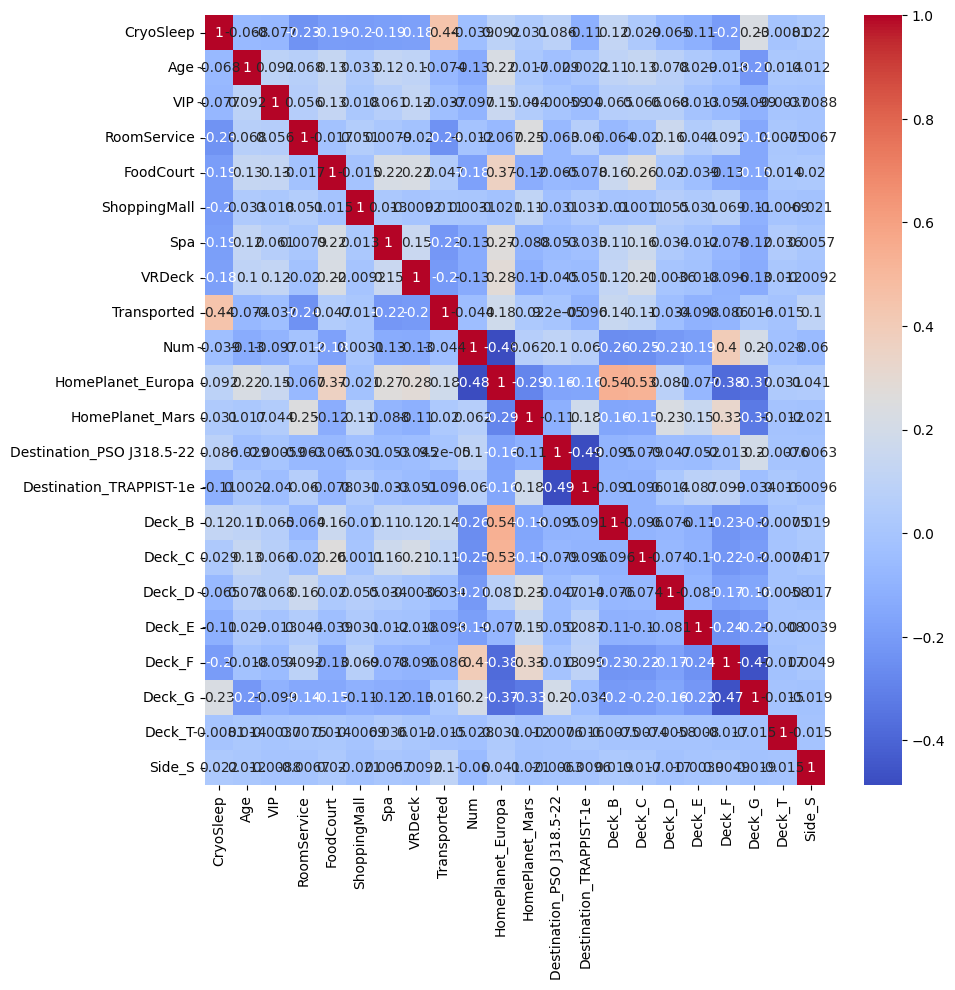

In [458]:
corr = df.corr()
print(df.corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot = True , cmap = "coolwarm")

Bulding the Neural Network:

In [459]:
x = df.drop('Transported',axis=1)
y=df['Transported']

In [460]:
x.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,HomePlanet_Europa,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,1,1,0,0,0,0,0,0,0
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,0.0,0,...,0,1,0,0,0,0,1,0,0,1
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0.0,1,...,0,1,0,0,0,0,0,0,0,1
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0.0,1,...,0,1,0,0,0,0,0,0,0,1
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,1.0,0,...,0,1,0,0,0,0,1,0,0,1


In [461]:
y.head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

In [462]:
x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# **Scaling The Data:**

In [463]:
scaler = StandardScaler()

In [464]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [465]:
x_train.shape

(6954, 21)

In [466]:
x_test.shape

(1739, 21)

In [467]:
y_train.shape

(6954,)

In [468]:
y_test.shape

(1739,)

# **PCA:**

In [469]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

In [470]:
x_train.shape

(6954, 3)

In [471]:
!pip install keras-tuner

In [472]:
def build_model(hp):
  model = Sequential([
    layers.Dense(
        units=hp.Int('dense_1_units', min_value=16, max_value=512, step=16),
        activation=hp.Choice('dense_1_activation',values= ['relu','selu','tanh','elu','sigmoid']),
        input_dim=3
    ),
    layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.0001,0.0003,0.001,0.003,0.01])),
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [473]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [474]:
tuner_search = RandomSearch(build_model,objective='val_accuracy',max_trials=15,directory='output',project_name='SpaceShip_Titanic_1.2')

Reloading Tuner from output/SpaceShip_Titanic_1.2/tuner0.json


In [475]:
tuner_search.search(x_train,y_train,epochs=4,validation_split=0.2)

In [476]:
model = tuner_search.get_best_models(num_models=1)[0]

In [477]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 81 (324.00 Byte)
Trainable params: 81 (324.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


fitting the model:

In [478]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,initial_epoch=4)

Epoch 5/100
218/218 [==============================] - 2s 6ms/step - loss: 0.5817 - accuracy: 0.6907 - val_loss: 0.5614 - val_accuracy: 0.6970
Epoch 6/100
218/218 [==============================] - 1s 6ms/step - loss: 0.5772 - accuracy: 0.6996 - val_loss: 0.5598 - val_accuracy: 0.6981
Epoch 7/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5733 - accuracy: 0.7029 - val_loss: 0.5512 - val_accuracy: 0.7228
Epoch 8/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5688 - accuracy: 0.7078 - val_loss: 0.5556 - val_accuracy: 0.7119
Epoch 9/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5673 - accuracy: 0.7088 - val_loss: 0.5479 - val_accuracy: 0.7292
Epoch 10/100
218/218 [==============================] - 1s 4ms/step - loss: 0.5629 - accuracy: 0.7095 - val_loss: 0.5521 - val_accuracy: 0.7125
Epoch 11/100
218/218 [==============================] - 1s 5ms/step - loss: 0.5594 - accuracy: 0.7087 - val_loss: 0.5520 - val_accuracy: 0.69

In [479]:
model.evaluate(x_test,y_test)[1]

55/55 [==============================] - 0s 2ms/step - loss: 0.5490 - accuracy: 0.7039


0.7038527727127075

Random Forest:

In [480]:
rfc = RandomForestClassifier()

In [481]:
param_grid = [
    {"n_estimators": [10,100,200,500,1000], "max_depth": [None,3,5,10], "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(rfc,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 3, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [482]:
rfc_model = grid_search.best_estimator_

In [483]:
y_pred_rfc_train = rfc_model.predict(x_train)

In [484]:
print(f"Training Data Accuracy for Random Forest: {accuracy_score(y_train,y_pred_rfc_train)}")
print(f"Training Data Precision for Random Forest: {precision_score(y_train,y_pred_rfc_train)}")
print(f"Training Data Recall for Random Forest: {recall_score(y_train,y_pred_rfc_train)}")
print(f"Training Data F1 for Random Forest: {f1_score(y_train,y_pred_rfc_train)}")

Training Data Accuracy for Random Forest: 0.813920046016681
Training Data Precision for Random Forest: 0.89002828854314
Training Data Recall for Random Forest: 0.7191428571428572
Training Data F1 for Random Forest: 0.79551201011378


In [485]:
y_pred_rfc = rfc_model.predict(x_test)

In [486]:
print(f"Testing Data Accuracy for Random Forest: {accuracy_score(y_test,y_pred_rfc)}")
print(f"Testing Data Precision for Random Forest: {precision_score(y_test,y_pred_rfc)}")
print(f"Testing Data Recall for Random Forest: {recall_score(y_test,y_pred_rfc)}")
print(f"Testing Data F1 for Random Forest: {f1_score(y_test,y_pred_rfc)}")

Testing Data Accuracy for Random Forest: 0.7239792984473835
Testing Data Precision for Random Forest: 0.7703804347826086
Testing Data Recall for Random Forest: 0.6457858769931663
Testing Data F1 for Random Forest: 0.7026022304832713


Logistic Regression:

In [487]:
model_l = LogisticRegression()

In [488]:
model_l.fit(x_train,y_train)

LogisticRegression()

In [489]:
y_pred_train_log = model_l.predict(x_train)

In [490]:
print(f"Training Data Accuracy for Logistic Regression: {accuracy_score(y_train,y_pred_train_log)}")
print(f"Training Data Precision for Logistic Regression: {precision_score(y_train,y_pred_train_log)}")
print(f"Training Data Recall for Logistic Regression: {recall_score(y_train,y_pred_train_log)}")
print(f"Training Data F1 for Logistic Regression: {f1_score(y_train,y_pred_train_log)}")

Training Data Accuracy for Logistic Regression: 0.6032499280989359
Training Data Precision for Logistic Regression: 0.5988263536943185
Training Data Recall for Logistic Regression: 0.6414285714285715
Training Data F1 for Logistic Regression: 0.6193957787281004


In [491]:
y_pred_test_log = model_l.predict(x_test)

In [492]:
print(f"Testing Data Accuracy for Logistic Regression: {accuracy_score(y_test,y_pred_test_log)}")
print(f"Testing Data Precision for Logistic Regression: {precision_score(y_test,y_pred_test_log)}")
print(f"Testing Data Recall for Logistic Regression: {recall_score(y_test,y_pred_test_log)}")
print(f"Testing Data F1 for Logistic Regression: {f1_score(y_test,y_pred_test_log)}")

Testing Data Accuracy for Logistic Regression: 0.5991949396204715
Testing Data Precision for Logistic Regression: 0.5961742826780021
Testing Data Recall for Logistic Regression: 0.6389521640091116
Testing Data F1 for Logistic Regression: 0.616822429906542


SVC:

In [493]:
svc = SVC()

In [494]:
svc.fit(x_train,y_train)

SVC()

In [495]:
y_pred_svc = svc.predict(x_train)

In [496]:
print(f"Training Data Accuracy for SVC: {accuracy_score(y_train,y_pred_svc)}")
print(f"Training Data Precision for SVC: {precision_score(y_train,y_pred_svc)}")
print(f"Training Data Recall for SVC: {recall_score(y_train,y_pred_svc)}")
print(f"Training Data F1 for SVC: {f1_score(y_train,y_pred_svc)}")

Training Data Accuracy for SVC: 0.7118205349439172
Training Data Precision for SVC: 0.7956521739130434
Training Data Recall for SVC: 0.5751428571428572
Training Data F1 for SVC: 0.6676616915422885


In [497]:
y_pred_svc_t = svc.predict(x_test)

In [498]:
print(f"Testing Data Accuracy for SVC: {accuracy_score(y_test,y_pred_svc_t)}")
print(f"Testing Data Precision for SVC: {precision_score(y_test,y_pred_svc_t)}")
print(f"Testing Data Recall for SVC: {recall_score(y_test,y_pred_svc_t)}")
print(f"Testing Data F1 for SVC: {f1_score(y_test,y_pred_svc_t)}")

Testing Data Accuracy for SVC: 0.718803910293272
Testing Data Precision for SVC: 0.7960426179604262
Testing Data Recall for SVC: 0.5956719817767654
Testing Data F1 for SVC: 0.6814332247557003


Decision Trees:

In [499]:
dtc_g = DecisionTreeClassifier(criterion='gini')

In [500]:
dtc_g.fit(x_train,y_train)

DecisionTreeClassifier()

In [501]:
y_pred_dtc_g = dtc_g.predict(x_train)

In [502]:
print(f"Training Data Accuracy for Decision Tree: {accuracy_score(y_train,y_pred_dtc_g)}")
print(f"Training Data Precision for Decision Tree: {precision_score(y_train,y_pred_dtc_g)}")
print(f"Training Data Recall for Decision Tree: {recall_score(y_train,y_pred_dtc_g)}")
print(f"Training Data F1 for Decision Tree: {f1_score(y_train,y_pred_dtc_g)}")

Training Data Accuracy for Decision Tree: 0.9995685936151855
Training Data Precision for Decision Tree: 1.0
Training Data Recall for Decision Tree: 0.9991428571428571
Training Data F1 for Decision Tree: 0.9995712448192082


In [503]:
y_pred_dtc_g_t = dtc_g.predict(x_test)

In [504]:
print(f"Testing Data Accuracy for Decision Tree: {accuracy_score(y_test,y_pred_dtc_g_t)}")
print(f"Testing Data Precision for Decision Tree: {precision_score(y_test,y_pred_dtc_g_t)}")
print(f"Testing Data Recall for Decision Tree: {recall_score(y_test,y_pred_dtc_g_t)}")
print(f"Testing Data F1 for Decision Tree: {f1_score(y_test,y_pred_dtc_g_t)}")

Testing Data Accuracy for Decision Tree: 0.6572742955721679
Testing Data Precision for Decision Tree: 0.6532608695652173
Testing Data Recall for Decision Tree: 0.6845102505694761
Testing Data F1 for Decision Tree: 0.6685205784204672


In [505]:
dtc_e = DecisionTreeClassifier(criterion='entropy')

In [506]:
dtc_e.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [507]:
y_pred_dtc_e = dtc_e.predict(x_train)

In [508]:
print(f"Training Data Accuracy for Decision Tree (e): {accuracy_score(y_train,y_pred_dtc_e)}")
print(f"Training Data Precision for Decision Tree (e): {precision_score(y_train,y_pred_dtc_e)}")
print(f"Training Data Recall for Decision Tree (e): {recall_score(y_train,y_pred_dtc_e)}")
print(f"Training Data F1 for Decision Tree (e): {f1_score(y_train,y_pred_dtc_e)}")

Training Data Accuracy for Decision Tree (e): 0.9995685936151855
Training Data Precision for Decision Tree (e): 1.0
Training Data Recall for Decision Tree (e): 0.9991428571428571
Training Data F1 for Decision Tree (e): 0.9995712448192082


In [509]:
y_pred_dtc_e_t = dtc_e.predict(x_test)

In [510]:
print(f"Testing Data Accuracy for Decision Tree (e): {accuracy_score(y_test,y_pred_dtc_e_t)}")
print(f"Testing Data Precision for Decision Tree (e): {precision_score(y_test,y_pred_dtc_e_t)}")
print(f"Testing Data Recall for Decision Tree (e): {recall_score(y_test,y_pred_dtc_e_t)}")
print(f"Testing Data F1 for Decision Tree (e): {f1_score(y_test,y_pred_dtc_e_t)}")

Testing Data Accuracy for Decision Tree (e): 0.6515238642898218
Testing Data Precision for Decision Tree (e): 0.6494505494505495
Testing Data Recall for Decision Tree (e): 0.673120728929385
Testing Data F1 for Decision Tree (e): 0.6610738255033557


KNN:

In [511]:
from sklearn.neighbors import KNeighborsClassifier
neighbor = np.arange(1,10,1)
for n in neighbor:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(x_train,y_train)
  y_pred_knn = knn.predict(x_train)
  print(f"FOR NEIGHBOR = {n}")
  print(f"Training Data Accuracy for KNN (neighbors: {n}): {accuracy_score(y_train,y_pred_knn)}")
  print(f"Training Data Precision for KNN (neighbors: {n}): {precision_score(y_train,y_pred_knn)}")
  print(f"Training Data Recall for KNN (neighbors: {n}): {recall_score(y_train,y_pred_knn)}")
  print(f"Training Data F1 for KNN (neighbors: {n}): {f1_score(y_train,y_pred_knn)}")
  print('\n')
  y_pred_knn_t = knn.predict(x_test)
  print(f"Testing Data Accuracy for KNN (neighbors: {n}): {accuracy_score(y_test,y_pred_knn_t)}")
  print(f"Testing Data Precision for KNN (neighbors: {n}): {precision_score(y_test,y_pred_knn_t)}")
  print(f"Testing Data Recall for KNN (neighbors: {n}): {recall_score(y_test,y_pred_knn_t)}")
  print(f"Testing Data F1 for KNN (neighbors: {n}): {f1_score(y_test,y_pred_knn_t)}")
  print('\n\n')

FOR NEIGHBOR = 1
Training Data Accuracy for KNN (neighbors: 1): 0.9995685936151855
Training Data Precision for KNN (neighbors: 1): 0.9997142040583024
Training Data Recall for KNN (neighbors: 1): 0.9994285714285714
Training Data F1 for KNN (neighbors: 1): 0.9995713673381912


Testing Data Accuracy for KNN (neighbors: 1): 0.6693502012650949
Testing Data Precision for KNN (neighbors: 1): 0.6739380022962113
Testing Data Recall for KNN (neighbors: 1): 0.6685649202733486
Testing Data F1 for KNN (neighbors: 1): 0.6712407089765581



FOR NEIGHBOR = 2
Training Data Accuracy for KNN (neighbors: 2): 0.8369283865401208
Training Data Precision for KNN (neighbors: 2): 1.0
Training Data Recall for KNN (neighbors: 2): 0.676
Training Data F1 for KNN (neighbors: 2): 0.8066825775656324


Testing Data Accuracy for KNN (neighbors: 2): 0.7055779183438758
Testing Data Precision for KNN (neighbors: 2): 0.8070469798657718
Testing Data Recall for KNN (neighbors: 2): 0.5478359908883826
Testing Data F1 for KNN (n

In [512]:
#picking neighbors = 5
knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(x_train,y_train)
y_pred_knn = knn_final.predict(x_train)
print(f"Training Data Accuracy for KNN : {accuracy_score(y_train,y_pred_knn)}")
print(f"Training Data Precision for KNN : {precision_score(y_train,y_pred_knn)}")
print(f"Training Data Recall for KNN : {recall_score(y_train,y_pred_knn)}")
print(f"Training Data F1 for KNN : {f1_score(y_train,y_pred_knn)}")
print('\n')
y_pred_knn_t = knn_final.predict(x_test)
print(f"Testing Data Accuracy for KNN : {accuracy_score(y_test,y_pred_knn_t)}")
print(f"Testing Data Precision for KNN : {precision_score(y_test,y_pred_knn_t)}")
print(f"Testing Data Recall for KNN : {recall_score(y_test,y_pred_knn_t)}")
print(f"Testing Data F1 for KNN : {f1_score(y_test,y_pred_knn_t)}")


Training Data Accuracy for KNN : 0.7985332182916307
Training Data Precision for KNN : 0.8264385692068429
Training Data Recall for KNN : 0.7591428571428571
Training Data F1 for KNN : 0.7913626209977662


Testing Data Accuracy for KNN : 0.7124784358826912
Testing Data Precision for KNN : 0.7288135593220338
Testing Data Recall for KNN : 0.6856492027334852
Testing Data F1 for KNN : 0.7065727699530516


Gradient Boosting Classifier:

In [513]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

In [514]:
gbc.fit(x_train,y_train)

GradientBoostingClassifier()

In [515]:
y_pred_gbc=gbc.predict(x_train)

In [516]:
print(f"Training Data Accuracy for GBC : {accuracy_score(y_train,y_pred_gbc)}")
print(f"Training Data Precision for GBC : {precision_score(y_train,y_pred_gbc)}")
print(f"Training Data Recall for GBC : {recall_score(y_train,y_pred_gbc)}")
print(f"Training Data F1 for GBC : {f1_score(y_train,y_pred_gbc)}")

Training Data Accuracy for GBC : 0.7394305435720449
Training Data Precision for GBC : 0.7957252978276104
Training Data Recall for GBC : 0.6488571428571429
Training Data F1 for GBC : 0.7148253068932957


In [517]:
y_pred_gbc_t=gbc.predict(x_test)

In [518]:
print(f"Testing Data Accuracy for GBC : {accuracy_score(y_test,y_pred_gbc_t)}")
print(f"Testing Data Precision for GBC : {precision_score(y_test,y_pred_gbc_t)}")
print(f"Testing Data Recall for GBC : {recall_score(y_test,y_pred_gbc_t)}")
print(f"Testing Data F1 for GBC : {f1_score(y_test,y_pred_gbc_t)}")

Testing Data Accuracy for GBC : 0.7170787809085681
Testing Data Precision for GBC : 0.7566489361702128
Testing Data Recall for GBC : 0.6480637813211845
Testing Data F1 for GBC : 0.698159509202454


# **Using Random Forest Classifier:**

In [519]:
xf = x
yf = y

In [520]:
scaler = StandardScaler()

In [521]:
xf = scaler.fit_transform(xf)

In [522]:
pca = PCA(n_components = 3)
xf = pca.fit_transform(xf)
explained_variance = pca.explained_variance_ratio_

In [523]:
rfc_model.fit(xf,yf)

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=500)

In [524]:
df_final = pd.read_csv('/content/test.csv')

In [525]:
df_final.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [526]:
df_final.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [527]:
#People in CryoSleep don't pay for food etc
cols_to_be_zero = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cols_to_be_false = ['VIP']
condition = (df_final['CryoSleep']==True)
df_final.loc[~condition,cols_to_be_zero] = df_final.loc[~condition,cols_to_be_zero].fillna(0)
df_final.loc[~condition,cols_to_be_false] = df_final.loc[~condition,cols_to_be_false].fillna(False)

In [528]:
cols_to_be_zero = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cryo_col = ['CryoSleep']
cond = (df_final[cols_to_be_zero].eq(0).all(axis=1))
df_final.loc[~cond,cryo_col]=df_final.loc[~cond,cryo_col].fillna(True)

In [529]:
df_final['CryoSleep'].fillna(False,inplace=True)

In [530]:
df_final.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep         0
Cabin           100
Destination      92
Age              91
VIP              29
RoomService      25
FoodCourt        39
ShoppingMall     35
Spa              42
VRDeck           29
Name             94
dtype: int64

In [531]:
cabin_split = df_final['Cabin'].str.split('/',expand=True)
cabin_split.columns=['Deck','Num','Side']
new_df_final = pd.concat([df_final,cabin_split],axis=1)
df_final = new_df_final

In [532]:
df_final.drop(['Cabin'],axis=1,inplace=True)
df_final.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Num,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S


In [533]:
group_mean = df_final.groupby(['HomePlanet','CryoSleep'])['Age'].mean()
print(group_mean)

HomePlanet  CryoSleep
Earth       False        26.561716
            True         23.998586
Europa      False        35.279612
            True         32.922912
Mars        False        30.181648
            True         29.148352
Name: Age, dtype: float64


In [534]:
group_m = df_final.groupby(['HomePlanet','CryoSleep'],group_keys=True)['Age'].mean().reset_index(name='Age_mean')
df_final = df_final.merge(group_m,on=['HomePlanet','CryoSleep'],how='left')
df_final['Age']=df_final['Age'].fillna(df_final['Age_mean'])

In [535]:
df_final.drop(['Age_mean'],axis=1,inplace=True)
df_final.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Num,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S


In [538]:
df_final.drop(['Name'],axis=1,inplace=True)

In [539]:
df_final.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep         0
Destination      92
Age               3
VIP              29
RoomService      25
FoodCourt        39
ShoppingMall     35
Spa              42
VRDeck           29
Deck            100
Num             100
Side            100
dtype: int64

In [540]:
cat_features = ['HomePlanet','Destination','VIP','Deck','Num','Side']
df_final['HomePlanet'].fillna(df_final['HomePlanet'].mode()[0],axis=0,inplace=True)
df_final['Destination'].fillna(df_final['Destination'].mode()[0],axis=0,inplace=True)
df_final['VIP'].fillna(df_final['VIP'].mode()[0],axis=0,inplace=True)
df_final['Deck'].fillna(df_final['Deck'].mode()[0],axis=0,inplace=True)
df_final['Num'].fillna(df_final['Num'].mode()[0],axis=0,inplace=True)
df_final['Side'].fillna(df_final['Side'].mode()[0],axis=0,inplace=True)

In [541]:
df_final.isnull().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              3
VIP              0
RoomService     25
FoodCourt       39
ShoppingMall    35
Spa             42
VRDeck          29
Deck             0
Num              0
Side             0
dtype: int64

In [542]:
df_final['RoomService'].fillna(df_final['RoomService'].mean(),axis=0,inplace=True)
df_final['FoodCourt'].fillna(df_final['FoodCourt'].mean(),axis=0,inplace=True)
df_final['ShoppingMall'].fillna(df_final['ShoppingMall'].mean(),axis=0,inplace=True)
df_final['Spa'].fillna(df_final['Spa'].mean(),axis=0,inplace=True)
df_final['VRDeck'].fillna(df_final['VRDeck'].mean(),axis=0,inplace=True)
df_final['Age'].fillna(df_final['Age'].mean(),axis=0,inplace=True)

In [543]:
df_final.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
Num             0
Side            0
dtype: int64

In [544]:
print(f"Unique values for CryoSleep: {df_final['CryoSleep'].unique()}")
print(f"Unique values for HomePlanet: {df_final['HomePlanet'].unique()}")
print(f"Unique values for Destination: {df_final['Destination'].unique()}")
print(f"Unique values for VIP: {df_final['VIP'].unique()}")

Unique values for CryoSleep: [ True False]
Unique values for HomePlanet: ['Earth' 'Europa' 'Mars']
Unique values for Destination: ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22']
Unique values for VIP: [False  True]


In [545]:
df_final['Num']=df_final['Num'].astype(np.float64)

In [546]:
df_final=pd.get_dummies(data=df_final,columns=['HomePlanet','Destination','Deck','Side'],drop_first=True)

In [556]:
x_data_f = df_final.drop(['PassengerId'],axis=1)

In [557]:
x_data_f

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Num,HomePlanet_Europa,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,True,27.000000,False,0.0,0.0,0.0,0.0,0.0,3.0,0,...,0,1,0,0,0,0,0,1,0,1
1,False,19.000000,False,0.0,9.0,0.0,2823.0,0.0,4.0,0,...,0,1,0,0,0,0,1,0,0,1
2,True,31.000000,False,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,1,0,0,0,0,0,1
3,False,38.000000,False,0.0,6652.0,0.0,181.0,585.0,1.0,1,...,0,1,0,1,0,0,0,0,0,1
4,False,20.000000,False,10.0,0.0,635.0,0.0,0.0,5.0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,True,34.000000,False,0.0,0.0,0.0,0.0,0.0,1496.0,0,...,0,1,0,0,0,0,0,1,0,1
4273,False,42.000000,False,0.0,847.0,17.0,10.0,144.0,4.0,0,...,0,1,0,0,0,0,1,0,0,1
4274,True,29.148352,False,0.0,0.0,0.0,0.0,0.0,296.0,0,...,0,0,0,0,1,0,0,0,0,0
4275,False,35.279612,False,0.0,2680.0,0.0,0.0,523.0,297.0,1,...,0,1,0,0,1,0,0,0,0,0


In [558]:
x_data_f.isnull().sum()

CryoSleep                    0
Age                          0
VIP                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Num                          0
HomePlanet_Europa            0
HomePlanet_Mars              0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
Side_S                       0
dtype: int64

In [559]:
scaler = StandardScaler()
x_data_f = scaler.fit_transform(x_data_f)

In [560]:
pca = PCA(n_components = 3)
x_data_f = pca.fit_transform(x_data_f)
explained_variance = pca.explained_variance_ratio_

In [561]:
x_data_f.shape

(4277, 3)

In [562]:
y_pred_rfc=rfc_model.predict(x_data_f)

In [563]:
prediction = pd.DataFrame(df_final['PassengerId'])

In [565]:
prediction['Transported'] = y_pred_rfc

In [566]:
prediction

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [567]:
prediction.to_csv('SpaceShip_pred_1.0.csv',index=False)